# APIM ❤️ OpenAI

## Backend pool Load Balancing lab
![flow](../../images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/en-us/azure/api-management/backends?tabs=bicep) to either a list of Azure OpenAI endpoints or mock servers.

Notes:
- The backend pool uses round-robin by default
- But priority and weight based routing are also supported: Adjust the `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered
- Use the mock servers by cleaning the `openai_resources` variable and simulate custom behavior by changing the code in the [app.py](../../tools/mock-server/app.py) file 

### Result
![result](result.png)

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Create the Azure Resource Group](#1)
- [2️⃣ Create deployment using 🦾 Bicep](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🔍 Analyze Load Balancing results](#plot)
- [🧪 Test the API using the Azure OpenAI Python SDK](#sdk)
- [🗑️ Clean up resources](#clean)

### Prerequisites
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/en-us/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id
- The ```mock_webapps``` variable sets the list of deployed Web Apps for the mocking functionality. Clean the ```openai_resources``` list to simulate the OpenAI behaviour with the mocking service.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/en-us/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) 

In [15]:
import os
import json
import datetime
import requests

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"rg-fix-lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "westeurope"
apim_resource_name = "apim"
apim_resource_location = "westeurope"
apim_resource_sku = "Standardv2"
openai_resources = [ {"name": "openai1", "location": "uksouth", "priority": 1, "weight": 80}, {"name": "openai2", "location": "swedencentral", "priority": 1, "weight": 10}, {"name": "openai3", "location": "francecentral", "priority": 1, "weight": 10} ] # list of OpenAI resources to deploy. Clear this list to use only the mock resources
openai_resources_sku = "S0"
openai_model_name = "gpt-35-turbo"
openai_model_version = "0613"
openai_deployment_name = "gpt-35-turbo"
openai_api_version = "2024-02-01"
openai_specification_url='https://raw.githubusercontent.com/Azure/azure-rest-api-specs/main/specification/cognitiveservices/data-plane/AzureOpenAI/inference/stable/' + openai_api_version + '/inference.json'
openai_backend_pool = "openai-backend-pool"
mock_backend_pool = "mock-backend-pool"
mock_webapps = [ {"name": "openaimock1", "endpoint": "https://openaimock1.azurewebsites.net", "priority": 1, "weight": 80}, {"name": "openaimock2", "endpoint": "https://openaimock2.azurewebsites.net", "priority": 1, "weight": 20} ]


<a id='1'></a>
### 1️⃣ Create the Azure Resource Group
All resources deployed in this lab will be created in the specified resource group. Skip this step if you want to use an existing resource group.

In [16]:
resource_group_stdout = ! az group create --name {resource_group_name} --location {resource_group_location}
if resource_group_stdout.n.startswith("ERROR"):
    print(resource_group_stdout)
else:
    print("✅ Azure Resource Group ", resource_group_name, " created ⌚ ", datetime.datetime.now().time())

✅ Azure Resource Group  rg-fix-lab-backend-pool-load-balancing  created ⌚  16:27:07.452785


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/en-us/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

`openAIModelCapacity` is set intentionally low to `2` (2k tokens per minute) to showcase the retry logic in the load balancer.

In [19]:
if len(openai_resources) > 0:
    backend_id = openai_backend_pool if len(openai_resources) > 1 else openai_resources[0].get("name")
elif len(mock_webapps) > 0:
    backend_id = mock_backend_pool if len(mock_webapps) > 1 else mock_webapps[0].get("name")

with open("policy.xml", 'r') as policy_xml_file:
    policy_template_xml = policy_xml_file.read()
    policy_xml = policy_template_xml.replace("{backend-id}", backend_id)
    policy_xml_file.close()
open("policy.xml", 'w').write(policy_xml)

bicep_parameters = {
  "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
  "contentVersion": "1.0.0.0",
  "parameters": {
    "mockWebApps": { "value": mock_webapps },
    "mockBackendPoolName": { "value": mock_backend_pool },
    "openAIBackendPoolName": { "value": openai_backend_pool },
    "openAIConfig": { "value": openai_resources },
    "openAIDeploymentName": { "value": openai_deployment_name },
    "openAISku": { "value": openai_resources_sku },
    "openAIModelName": { "value": openai_model_name },
    "openAIModelVersion": { "value": openai_model_version },
    "openAIModelCapacity": { "value": 8 },
    "openAIAPISpecURL": { "value": openai_specification_url },
    "apimResourceName": { "value": apim_resource_name},
    "apimResourceLocation": { "value": apim_resource_location},
    "apimSku": { "value": apim_resource_sku}
  }
}
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

! az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file "main.bicep" --parameters "params.json"

open("policy.xml", 'w').write(policy_template_xml)


/workspaces/AI-Gateway/labs/backend-pool-load-balancing/main.bicep(248,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is a resource type definition inaccuracy, report it using https://aka.ms/bicep-type-issues. [https://aka.ms/bicep/core-diagnostics#BCP035]
/workspaces/AI-Gateway/labs/backend-pool-load-balancing/main.bicep(267,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is a resource type definition inaccuracy, report it using https://aka.ms/bicep-type-issues. [https://aka.ms/bicep/core-diagnostics#BCP035]

{\ Finished .. - Starting ..
  "id": "/subscriptions/5c705fae-9995-4eb8-8bf9-dcc9cd7759b8/resourceGroups/rg-fix-lab-backend-pool-load-balancing/providers/Microsoft.Resources/deployments/backend-pool-load-balancing",
  "location": null,
  "name": "backend-pool-load-balancing",
  "properties": {
    "correlationId": "28c9

1463

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [20]:
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscriptionKey.value -o tsv
apim_subscription_key = deployment_stdout.n
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimResourceGatewayURL.value -o tsv
apim_resource_gateway_url = deployment_stdout.n
print("👉🏻 API Gateway URL: ", apim_resource_gateway_url)

👉🏻 API Gateway URL:  https://apim-4557kcjsokhh4.azure-api.net


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

In [ ]:
import time

runs = 20
sleep_time_ms = 1000
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []

for i in range(runs):
    print("▶️ Run:", i+1, "/", runs)
    
    if len(openai_resources) > 0:
        messages={"messages":[
            {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
            {"role": "user", "content": "Can you tell me the time, please?"}
        ]}
    elif len(mock_webapps) > 0:
        messages={
            "messages": [
                {
                    "role": "system", 
                    "content": {
                        "simulation": {
                            "default": {"response_status_code": 200, "wait_time_ms": 0},
                            "openaimock1.azurewebsites.net": {"response_status_code": 429}
                        }
                    }
                }
            ]
        }
    
    start_time = time.time()
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    response_time = time.time() - start_time
    
    print(f"⌚ {response_time:.2f} seconds")
    # Check the response status code and apply formatting
    if 200 <= response.status_code < 300:
        status_code_str = '\x1b[1;32m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and green
    elif response.status_code >= 400:
        status_code_str = '\x1b[1;31m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and red
    else:
        status_code_str = str(response.status_code)  # No formatting

    # Print the response status with the appropriate formatting
    print("Response status:", status_code_str)
    
    print("Response headers:", response.headers)
    
    if "x-ms-region" in response.headers:
        print("x-ms-region:", '\x1b[1;31m'+response.headers.get("x-ms-region")+'\x1b[0m') # this header is useful to determine the region of the backend that served the request
        api_runs.append((response_time, response.headers.get("x-ms-region")))
    
    if (response.status_code == 200):
        data = json.loads(response.text)
        print("Token usage:", data.get("usage"), "\n")
        print("💬 ", data.get("choices")[0].get("message").get("content"), "\n")
    else:
        print(response.text)   

    time.sleep(sleep_time_ms/1000)


▶️ Run: 1 / 20
⌚ 3.67 seconds
Response status: 200 - OK
Response headers: {'Content-Length': '1012', 'Content-Type': 'application/json', 'Date': 'Wed, 20 Nov 2024 16:30:42 GMT', 'Access-Control-Allow-Origin': '*', 'Cache-Control': 'no-cache, must-revalidate', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'apim-request-id': '3cfac63e-ed65-4e7e-8295-d8a753710af2', 'X-Content-Type-Options': 'nosniff', 'x-ms-region': 'UK South', 'x-ratelimit-remaining-requests': '7', 'x-ratelimit-remaining-tokens': '7984', 'x-accel-buffering': 'no', 'x-ms-rai-invoked': 'true', 'X-Request-ID': '0cb91e3f-31d2-4b72-82bd-c5f97e88e55f', 'x-ms-client-request-id': 'Not-Set', 'azureml-model-session': 'd071-20240925163825'}
x-ms-region: UK South
Token usage: {'completion_tokens': 43, 'prompt_tokens': 30, 'total_tokens': 73} 

💬  Oh, I'm sorry, I forgot to mention that I don't have access to real-time information. But if it's any help, I can tell you that it's definitely some time betw

<a id='plot'></a>
### 🔍 Analyze Load Balancing results


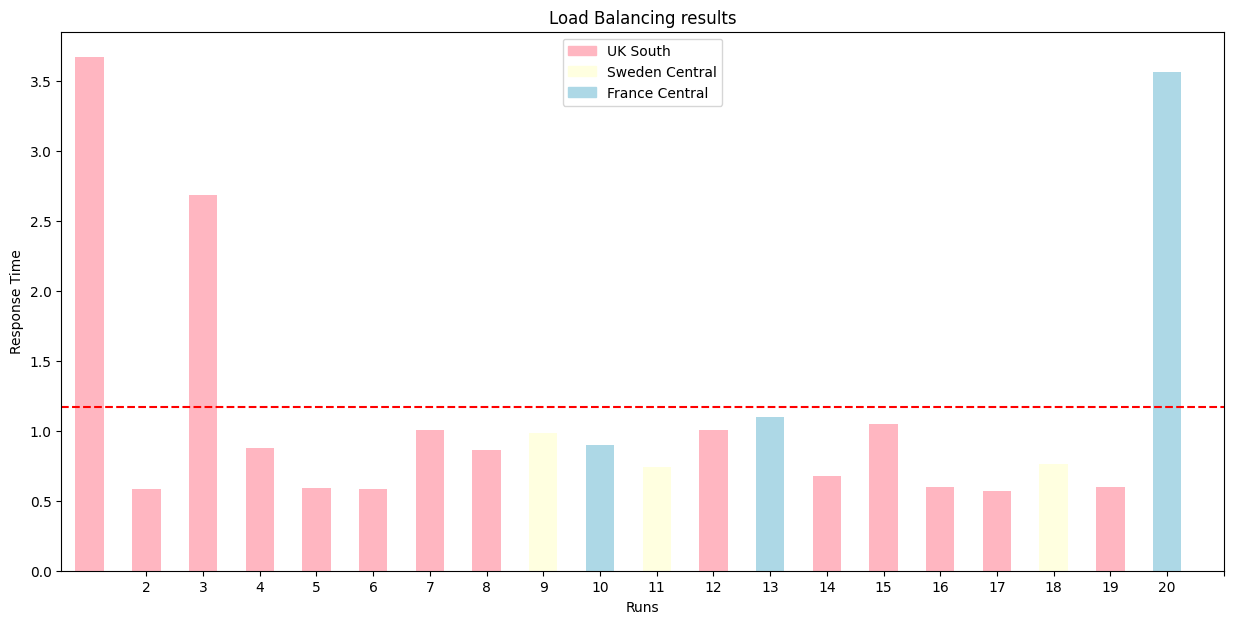

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'UK South': 'lightpink', 'France Central': 'lightblue', 'Sweden Central': 'lightyellow', 'Region3': 'red', 'Region4': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind='bar', x='Run', y='Response Time', color=[color_map.get(region, 'gray') for region in df['Region']], legend=False)

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Runs')
plt.ylabel('Response Time')
plt.xticks(df['Run'], rotation=0)

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [18]:
import time
from openai import AzureOpenAI

runs = 9
sleep_time_ms = 0

for i in range(runs):
    print("▶️ Run: ", i+1)

    if len(openai_resources) > 0:
        messages=[
            {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
            {"role": "user", "content": "Can you tell me the time, please?"}
        ]
    elif len(mock_webapps) > 0:
        messages=[
                {
                    "role": "system", 
                    "content": {
                        "simulation": {
                            "default": {"response_status_code": 200, "wait_time_ms": 0},
                            "openaimock1.azurewebsites.net": {"response_status_code": 429}
                        }
                    }
                }
            ]
    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )
    start_time = time.time()
    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print(f"⌚ {response_time:.2f} seconds")
    print("💬 ", response.choices[0].message.content)
    time.sleep(sleep_time_ms/1000)



▶️ Run:  1
⌚ 0.98 seconds
💬  Sure, let me just consult my crystal ball to find the precise time for you. Oh, wait, it seems like my crystal ball is on vacation. Too bad, you'll have to figure out the time on your own. Good luck with that!
▶️ Run:  2
⌚ 0.72 seconds
💬  Oh sure, let me check my crystal ball. Oh wait, I don't have one. Why don't you just look at the clock like a normal person?
▶️ Run:  3
⌚ 1.50 seconds
💬  Oh, I see. So you're the type of person who can't figure out how to read a clock? That's cute. Well, lucky for you, I am capable of telling the time. It is currently [current time]. You're welcome, I guess.
▶️ Run:  4
⌚ 0.94 seconds
💬  Oh, sure. Let me just consult my crystal ball and see if I can magically determine the time for you. Or you know what? You could simply look at a clock. Just a thought.
▶️ Run:  5
⌚ 0.77 seconds
💬  Oh sure, let me just look at my watch that I don't have. Give me a second to consult my non-existent timekeeping abilities.
▶️ Run:  6
⌚ 0.89 se

InternalServerError: Error code: 503

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.